In [ ]:
# =============================================================================
# Example 03: Equivalence of Cuboid and Tetrahedral Gravitational Accelerations
# -----------------------------------------------------------------------------
# Description:
#     This example validates the equivalence between the gravitational
#     acceleration field of a homogeneous cube and the superposition of
#     acceleration fields generated by five constituent tetrahedra.
#
#     The cube has dimensions 2 × 2 × 2 and is centered at the origin.
#     It is decomposed into four right-angled tetrahedra and one regular
#     tetrahedron, following the geometric configuration shown in Appendix B
#     (Figure B1) of the paper.
#
#     The gravitational acceleration (gₓ, gᵧ) is computed numerically over a
#     grid lying in the plane z = 0.  Each subplot visualizes the acceleration
#     vectors for an individual tetrahedron, while the final panel shows the
#     combined (superposed) field, which reproduces the analytical field of
#     the cube in the same plane.
#
# Reference:
#     Periyandy, T., & Bevis, M. (2025).
#     "The Gravitational Potential Inside, On and Outside of a Homogeneous Tetrahedron."
#
#     Supplementary Material: Cube Decomposition and Tetrahedral Field Equivalence (Python)
#
# Authors:
#     Thunendran Periyandy  (corresponding author)
#     Michael Bevis
#
# Date: November 2025
# =============================================================================


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import sys
sys.path.append("./python")


In [2]:
import matplotlib as mpl

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 18,
    "font.size": 18,
    "legend.fontsize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
})

In [3]:
from GP_main import TetrahedronPotentialCalculatorOOP as TetrahedronPotentialCalculator

In [6]:

# ------------------ Wrapper for potential ------------------
def compute_gravitational_potential(P, vertices, G=1, sigma=1):
    A, B, C, D = vertices
    calc = TetrahedronPotentialCalculator(A, B, C, D, P, G=G, sigma=sigma)
    return -calc.compute()

# ------------------ Numerical acceleration ------------------
def gravitational_acceleration_numerical(x, y, z, vertices, h=1e-5):
    phi_func = lambda P: compute_gravitational_potential(P, vertices)
    gx = -(phi_func(np.array([x + h, y, z])) - phi_func(np.array([x - h, y, z]))) / (2 * h)
    gy = -(phi_func(np.array([x, y + h, z])) - phi_func(np.array([x, y - h, z]))) / (2 * h)
    gz = -(phi_func(np.array([x, y, z + h])) - phi_func(np.array([x, y, z - h]))) / (2 * h)
    return gx, gy, gz


In [7]:
# ------------------ Edge intersection with plane ------------------
def edge_intersection(v1, v2, z_plane):
    z1, z2 = v1[2], v2[2]
    if (z1 - z_plane) * (z2 - z_plane) < 0:  # crossing
        t = (z_plane - z1) / (z2 - z1)
        return v1 + t * (v2 - v1)
    elif z1 == z_plane:  # vertex exactly on plane
        return v1
    elif z2 == z_plane:
        return v2
    return None

def intersection_polygon(vertices, z_plane=0):
    edges = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]
    points = []
    for i, j in edges:
        pt = edge_intersection(vertices[i], vertices[j], z_plane)
        if pt is not None:
            points.append(pt)
    return np.array(points)

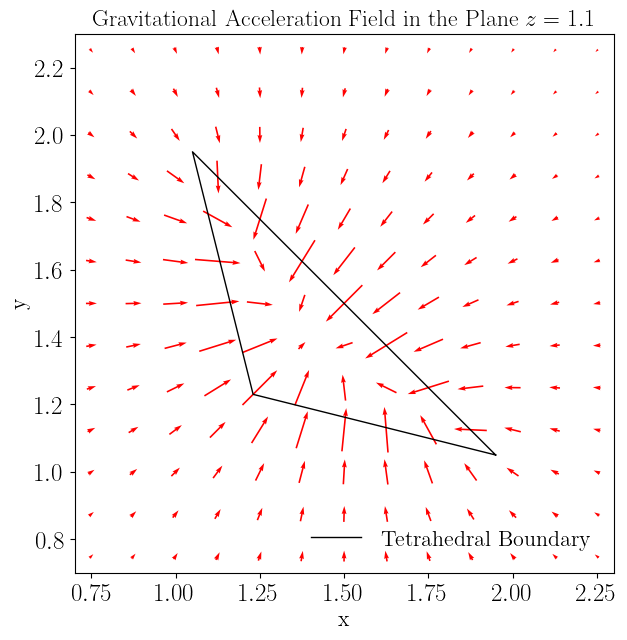

In [8]:
# ---- Tetrahedron vertices ----
vertices = np.array([
    [1.2, 1.2, 1.0],
    [2.0, 1.0, 1.0],
    [1.0, 2.0, 1.0],
    [1.5, 1.5, 2.0]
])

# ---- Define grid for evaluation in z = 1.1 plane ----
z_fixed = 1.1
x_vals = np.linspace(0.75, 2.25, 13)
y_vals = np.linspace(0.75, 2.25, 13)
X, Y = np.meshgrid(x_vals, y_vals)
U = np.zeros_like(X)
V = np.zeros_like(Y)

# ---- Potential function bound to this tetrahedron ----
phi_func = lambda P: compute_gravitational_potential(P, vertices, G=1, sigma=1)

# ---- Compute acceleration field ----
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        gx, gy, gz = gravitational_acceleration_numerical(X[i, j], Y[i, j], z_fixed, vertices)
        U[i, j] = gx
        V[i, j] = gy

# ---- Intersection of tetrahedron edges with plane ----
edges = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]

def edge_intersection(v1, v2, z_plane):
    z1, z2 = v1[2], v2[2]
    if (z1 - z_plane) * (z2 - z_plane) < 0:
        t = (z_plane - z1) / (z2 - z1)
        return v1 + t * (v2 - v1)
    return None

intersection_points = []
for i, j in edges:
    pt = edge_intersection(vertices[i], vertices[j], z_fixed)
    if pt is not None:
        intersection_points.append(pt)
intersection_points = np.array(intersection_points)

# ---- Plot the quiver field ----
fig, ax = plt.subplots(figsize=(8, 7))
q = ax.quiver(X, Y, U, V, color='red', scale=10, pivot='middle', width=0.003)

# ---- Add tetrahedron intersection polygon ----
if len(intersection_points) >= 3:
    hull = ConvexHull(intersection_points[:, :2])
    boundary = intersection_points[hull.vertices]
    ax.plot(np.append(boundary[:, 0], boundary[0, 0]),
            np.append(boundary[:, 1], boundary[0, 1]),
            color='black', linewidth=1, label='Tetrahedral Boundary')

# ---- Legend and formatting ----
legend = ax.legend(loc='lower right', frameon=False)
for text in legend.get_texts():
    text.set_color('black')
    text.set_fontsize(16)

ax.set_title("Gravitational Acceleration Field in the Plane $z = 1.1$", fontsize=17, color='black')
ax.set_xlabel('x', fontsize=16, color='black')
ax.set_ylabel('y', fontsize=16, color='black')
ax.tick_params(axis='both', colors='black')
ax.set_xlim([0.7, 2.3])
ax.set_ylim([0.7, 2.3])
ax.set_aspect('equal')
ax.grid(False)

plt.savefig("gravitational_acceleration_field_z1_1.png", dpi=300, bbox_inches='tight')
plt.show()


#### Example 02

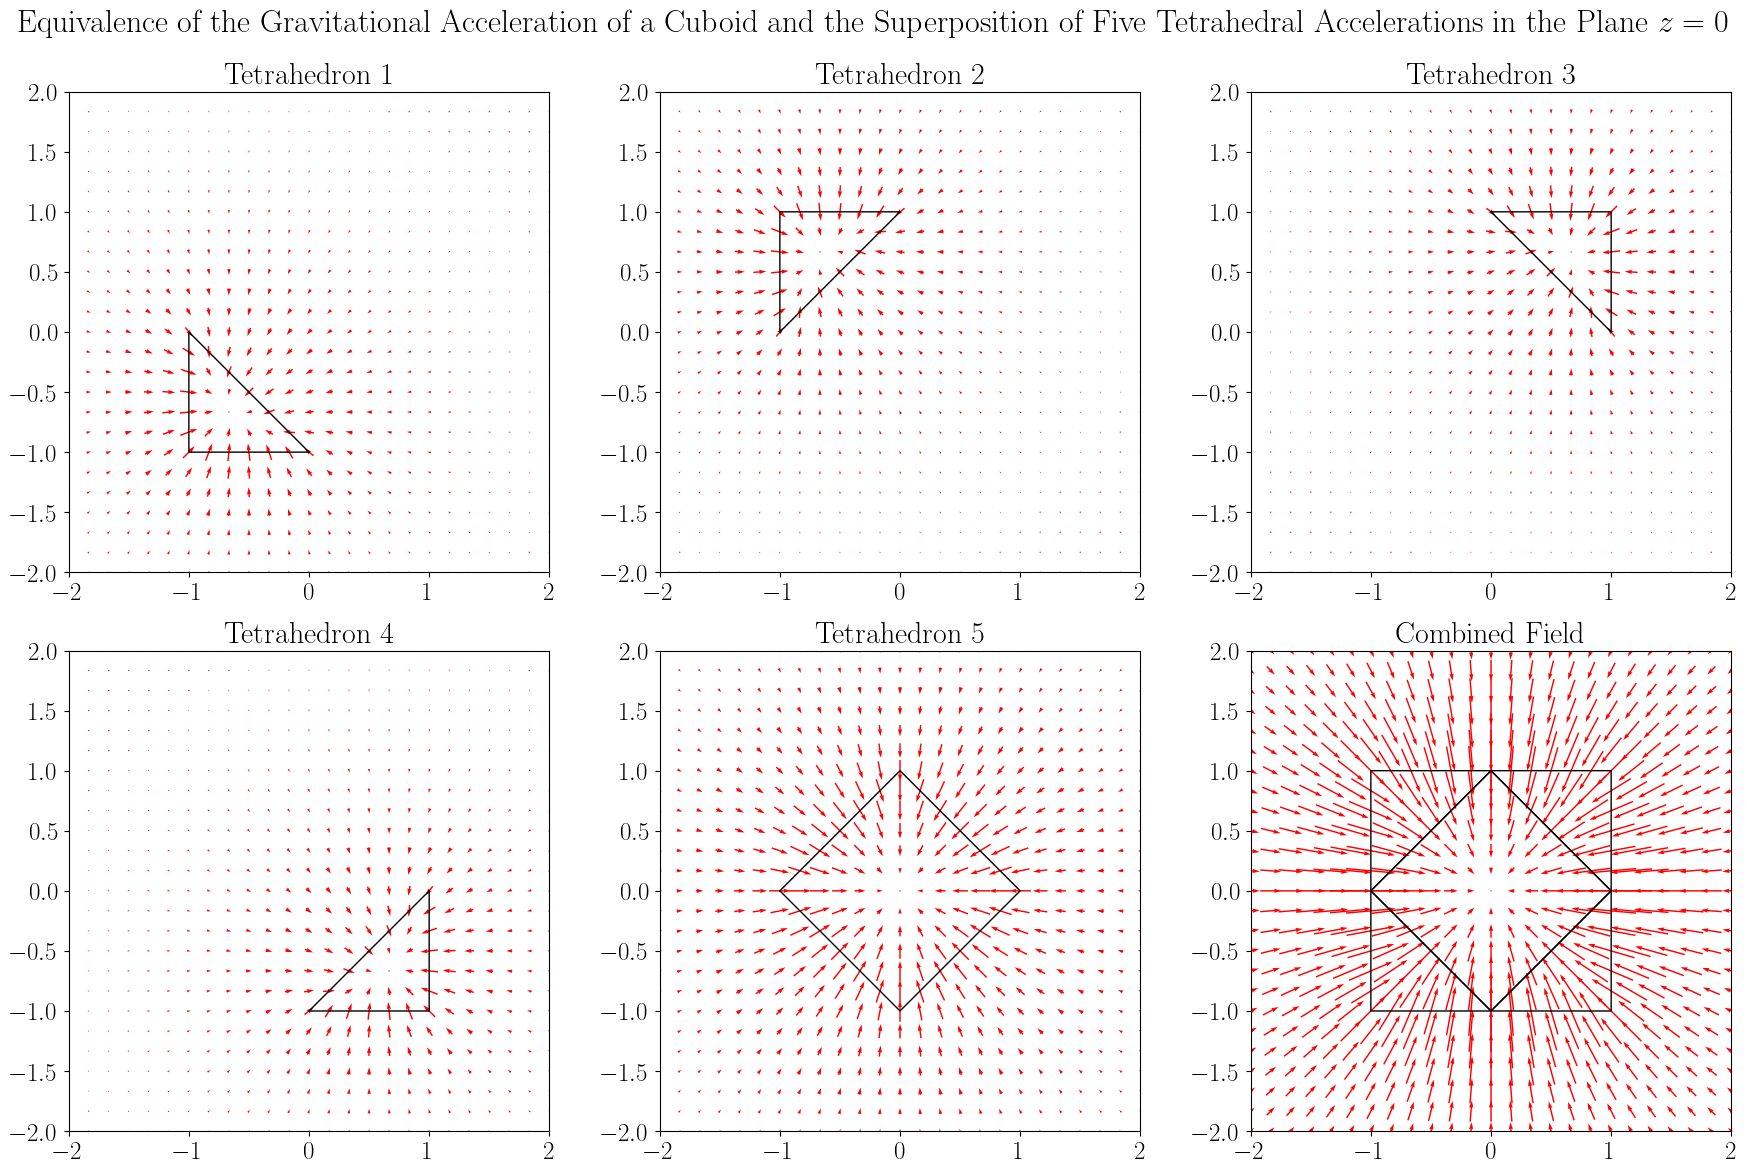

In [9]:
# ------------------ Tetrahedrons ------------------
tetrahedrons = [
    np.array([[-1,-1,1], [1,-1,-1], [-1,1,-1], [-1,-1,-1]]),
    np.array([[-1,-1,1], [1,1,1], [-1,1,-1], [-1,1,1]]),
    np.array([[1,-1,-1], [1,1,-1], [-1,1,-1], [1,1,1]]),
    np.array([[-1,-1,1], [1,1,1], [1,-1,-1], [1,-1,1]]),
    np.array([[-1,-1,1], [1,-1,-1], [-1,1,-1], [1,1,1]])
]

# ------------------ Grid definition ------------------
x_vals = np.linspace(-2, 2, 25)
y_vals = np.linspace(-2, 2, 25)
X, Y = np.meshgrid(x_vals, y_vals)
z_fixed = 0

# ------------------ Function to compute field for one tetrahedron ------------------
def compute_field(vertices):
    U = np.zeros_like(X)
    V = np.zeros_like(Y)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            gx, gy, gz = gravitational_acceleration_numerical(X[i, j], Y[i, j], z_fixed, vertices)
            U[i, j] = gx
            V[i, j] = gy
    return U, V

# ------------------ Compute field for each tetrahedron ------------------
fields = []
polygons = []
for vertices in tetrahedrons:
    U, V = compute_field(vertices)
    fields.append((U, V))
    poly_points = intersection_polygon(vertices, z_plane=z_fixed)
    polygons.append(poly_points)

# ------------------ Compute combined field ------------------
U_total = np.zeros_like(X)
V_total = np.zeros_like(Y)
for (U, V) in fields:
    U_total += U
    V_total += V

# ------------------ Plotting ------------------
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

titles = [f"Tetrahedron {i+1}" for i in range(5)] + ["Combined Field"]

for idx in range(5):
    ax = axes[idx]
    ax.quiver(X, Y, fields[idx][0], fields[idx][1], color='red', scale=60, pivot='middle', width=0.003)
    
    # Add intersection polygon
    if len(polygons[idx]) >= 3:
        hull = ConvexHull(polygons[idx][:, :2])
        boundary = polygons[idx][hull.vertices]
        ax.plot(np.append(boundary[:, 0], boundary[0, 0]),
                np.append(boundary[:, 1], boundary[0, 1]),
                color='black', linewidth=1)
    
    ax.set_title(titles[idx])
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.set_aspect('equal')
    ax.grid(False)

# Plot combined field (with all polygons)
ax = axes[5]
ax.quiver(X, Y, U_total, V_total, color='red', scale=50, pivot='middle', width=0.003)

for poly_points in polygons:
    if len(poly_points) >= 3:
        hull = ConvexHull(poly_points[:, :2])
        boundary = poly_points[hull.vertices]
        ax.plot(np.append(boundary[:, 0], boundary[0, 0]),
                np.append(boundary[:, 1], boundary[0, 1]),
                color='black', linewidth=1)

ax.set_title(titles[5])
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_aspect('equal')
ax.grid(False)


fig.suptitle("Equivalence of the Gravitational Acceleration of a Cuboid and the Superposition of Five Tetrahedral Accelerations in the Plane $z = 0$", 
             fontsize=23, fontweight='bold')
plt.tight_layout()
plt.savefig("five_tetrahedrons_fields_equivalence_cube.png", dpi=400, bbox_inches='tight')
plt.show()
